Making numpy array from images...
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28  Loading done.


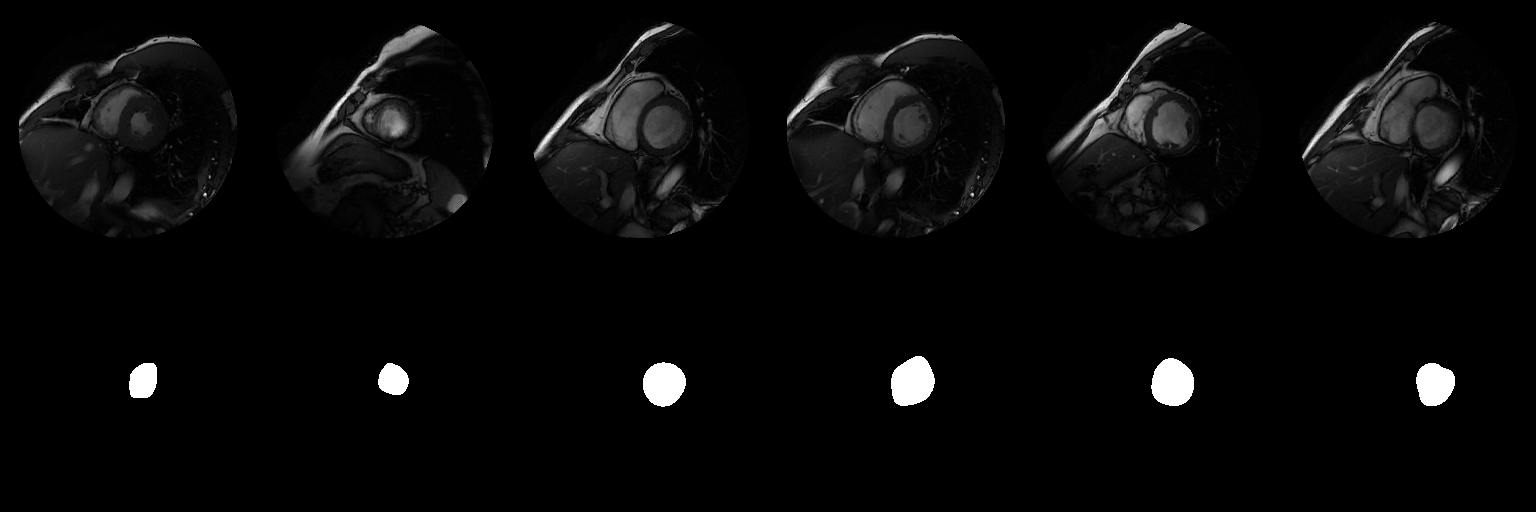

Making numpy array from images...
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10  Loading done.


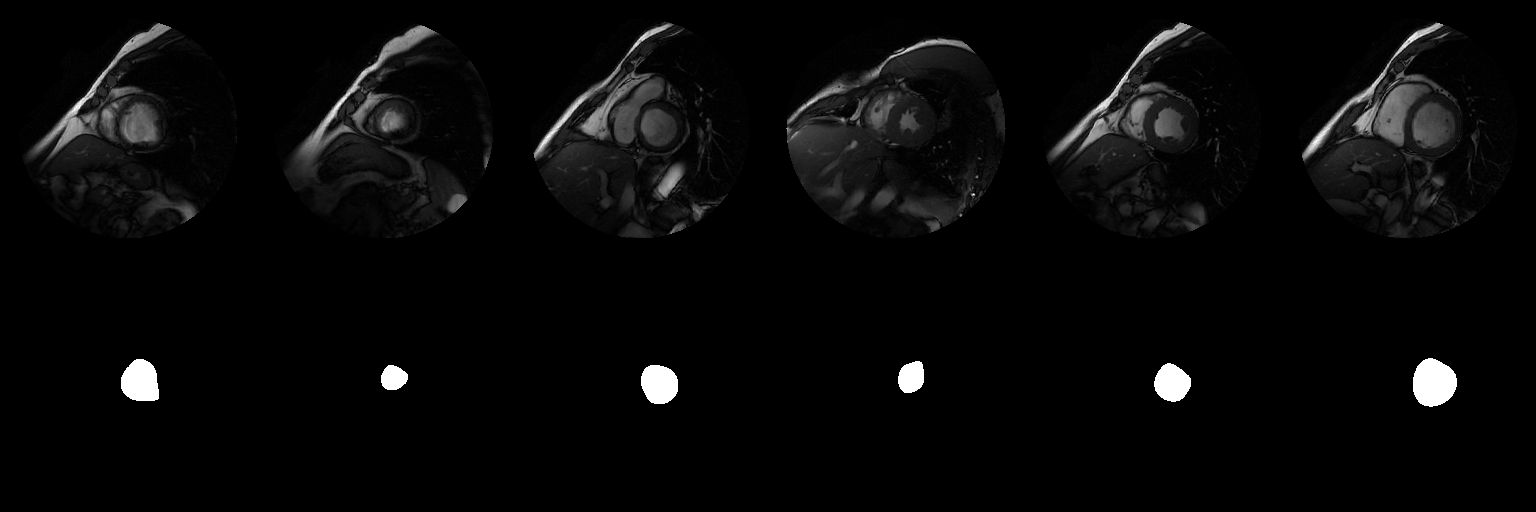

Loading and preprocessing train data...


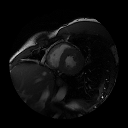

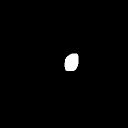

Creating and compiling model...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
____________________________________________________________

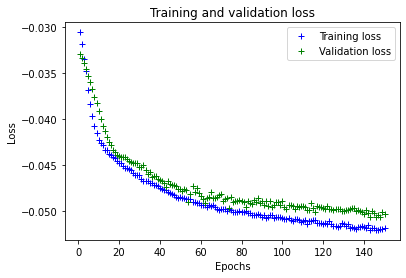

Loading and preprocessing test data...
Loading saved weights...
Predicting masks on test data...
5/5 [==============================] - 1s 37ms/step
0 0.06697596121078139
1 0.003940884161400999
2 0.028565900597065166
3 0.021616283595477
4 0.060511992897868946
5 0.028168094290440576
6 0.0358872121599334
7 0.04269190176721139
8 0.055775590678384133
9 0.08428112117572609
0.042841494253428904


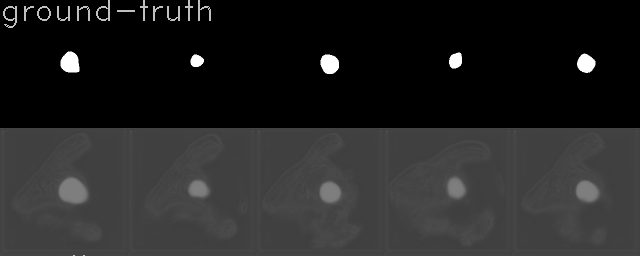

In [3]:
# -*- coding: utf-8 -*-
"""report_DeepLab V3+.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1jhZ7ik1Qbgk_OEAy8I0mT-WCermh4j59
"""

from __future__ import print_function

import os
import numpy as np

import cv2




image_rows = 256
image_cols = 256
skip = 1

def read_imgs(img_path, mask_path):

    images = os.listdir(img_path) # 파일이름 저장 리스트
    total = len(images)  # 파일갯수

    mask_images = os.listdir(mask_path)  # 마스크
    mask_total = len(mask_images)

    imgs = np.zeros((total//skip, image_rows, image_cols), dtype=np.uint8)
    mask_imgs = np.zeros((mask_total//skip, image_rows, image_cols), dtype=np.uint8)

    if(total != mask_total):
        print ('Error in number of images and mask_images')
        return imgs,mask_imgs

    i = 0
    print('Making numpy array from images...')
    for image_name in images:
        if i % skip == 0 and i//skip < total//skip :
            print (i, i//skip)
            img = cv2.imread(os.path.join(img_path, image_name), cv2.IMREAD_GRAYSCALE)
            tmp = cv2.resize(img, (image_cols, image_rows), interpolation=cv2.INTER_CUBIC)
            imgs[i//skip] = tmp

            img = cv2.imread(os.path.join(mask_path, image_name), cv2.IMREAD_GRAYSCALE)
            tmp = cv2.resize(img, (image_cols, image_rows), interpolation=cv2.INTER_CUBIC)
            mask_imgs[i//skip] = tmp
        i += 1
    print(str(total//skip) + '  Loading done.')

    return imgs, mask_imgs

from google.colab.patches import cv2_imshow

def vis_img_mask(imgs, mask_imgs, wn):

    size = int(imgs.shape[0]/5)
    w = imgs.shape[2]
    h = imgs.shape[1]
    t_img = np.zeros((2*h,6*w), np.uint8)
    
    for i in range (5):
        t_img[0:h,i*w:i*w+w] = imgs[i*size]
        t_img[h:h+h,i*w:i*w+w] = mask_imgs[i*size]
    t_img[0:h,5*w:5*w+w] = imgs[imgs.shape[0]-1]
    t_img[h:h+h,5*w:5*w+w] = mask_imgs[imgs.shape[0]-1]

    cv2_imshow(t_img)


data_dir = 'drive/MyDrive/python/data/raw-cmr-small/'

def create_train_data():

    imgs, mask_imgs = read_imgs(data_dir+'train', data_dir+'train_mask')
    np.save('imgs_train.npy', imgs)
    np.save('imgs_mask_train.npy', mask_imgs)

    vis_img_mask(imgs, mask_imgs, 'train')


def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train


def create_test_data():

    imgs, mask_imgs = read_imgs(data_dir+'test', data_dir+'test_mask')
    np.save('imgs_test.npy', imgs)
    np.save('imgs_mask_test.npy', mask_imgs)

    vis_img_mask(imgs, mask_imgs, 'test')


def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_mask_test = np.load('imgs_mask_test.npy')
    return imgs_test, imgs_mask_test

if __name__ == '__main__':
    create_train_data()
    create_test_data()

"""[ 구글 colab 에서의 unet train.py 예제 프로그램 ]


---


"""

# npy 영상을 읽어 (img_rows, img_cols) 크기로 영상을 resize 하고 위 keras data 형식으로 
# 누적하여 만들어줌.  
# 영상을 255로 나누어 level을 정규화 하고 u-net 에 입력하여 train 하고 test 함.

from __future__ import print_function
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Dropout, Conv2D, Conv3D
from keras.layers import MaxPooling2D, MaxPooling3D, Conv2DTranspose, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.layers import Reshape, Dense, multiply, Add, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import models
from keras import callbacks

img_rows = 128  # u-net 입력영상 높이
img_cols = 128   # u-net 입력영상 너비
ch = 3

smooth = 1.

#data_path = 'drive/My Drive/raw-cmr-small/'
data_path = './'

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

def load_train_data():
    imgs_train = np.load(data_path+'imgs_train.npy')
    imgs_mask_train = np.load(data_path+'imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

def load_test_data():
    imgs_test = np.load(data_path+'imgs_test.npy')
    imgs_mask_test = np.load(data_path+'imgs_mask_test.npy')
    return imgs_test, imgs_mask_test

# 테스트 결과를 dice_coef로 평가, 완전히 겹치면 1로 100%, 0 이면 0%
# 테스트 결과는 테스트 영상으로 확인
# y_true : 테스트 영상의 나와야 할 결과 
# y_pred : 테스트 영상을 입력했을 때 u-net 결과



def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# u-net 모델
def get_unet2():

    inputs = Input((img_rows, img_cols, ch))  # 입력 형식

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)





    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)


  


    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), 
           padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), 
           padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), 
           padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), 
           padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    #conv10 = Conv2D(2, 1, activation='softmax')(conv9)
    #model = Model(input=inputs, output=conv10)
    #model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy', 
    #                metrics=['accuracy'])

    return model



# def preprocess(imgs):

#     # 4D keras 데이타 형식의 numpy 배열 만들기, imgs.shape[0]가 영상 개수
#     # imgs 는 data.py에서 만들어 저장한 파일
#     imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, ch), dtype=np.uint8)

#     for i in range(imgs.shape[0]):
#         tmp1 = cv2.resize(imgs[i], (img_cols, img_rows), 
#                     interpolation=cv2.INTER_CUBIC)
#         # tmp1은 (img_rows, img_cols) 크기의 2D 영상. 
#         # 이 tmp1을 (imgs.shape[0], img_rows, img_cols, 1) 4D 배열에 넣기
#         imgs_p[i,:,:,0] = tmp1  # ch이 1 이상인 경우 의미에 맞게 추가
#     return imgs_p

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, ch), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        tmp1 = cv2.resize(imgs[i], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
        imgs_p[i,:,:,0] = tmp1
        imgs_p[i,:,:,1] = tmp1
        imgs_p[i,:,:,2] = tmp1

    return imgs_p

# def preprocess_mask(imgs):
#     imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.uint8)
#     for i in range(imgs.shape[0]):
#         tmp = cv2.resize(imgs[i], (img_cols, img_rows), 
#                          interpolation=cv2.INTER_CUBIC)
#         imgs_p[i,:,:,0] = tmp
#         #imgs_p[i,:,:,1] = 255-tmp
#     return imgs_p

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    output_s = Concatenate()([outputs1, outputs2])
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(output_s)
    model = Model(inputs, conv10)

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    #conv10 = Conv2D(2, 1, activation='softmax')(output_s)
    #model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy', 
    #                metrics=['accuracy'])


    #model = Model(inputs, outputs)
    return model

def preprocess(imgs):

    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, ch), dtype=np.uint8)

    for i in range(imgs.shape[0]):
        tmp1 = cv2.resize(imgs[i], (img_cols, img_rows), 
                    interpolation=cv2.INTER_CUBIC)
        imgs_p[i,:,:,0] = tmp1  
        imgs_p[i,:,:,1] = tmp1  
        imgs_p[i,:,:,2] = tmp1  
    return imgs_p

def preprocess_mask(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        tmp = cv2.resize(imgs[i], (img_cols, img_rows), 
                         interpolation=cv2.INTER_CUBIC)
        imgs_p[i,:,:,0] = tmp
        #imgs_p[i,:,:,1] = 255-tmp
    return imgs_p

def train_and_predict():
    print('Loading and preprocessing train data...')
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess_mask(imgs_mask_train)

    t_img = imgs_train[0, :, :, 0]
    
    from google.colab.patches import cv2_imshow
    cv2_imshow(t_img)
    #cv2.imshow("img", t_img)
    #cv2.moveWindow("img", 20, 20);
    #cv2.waitKey(100)

    t_img = imgs_mask_train[0, :, :, 0]
    cv2_imshow(t_img)
    #cv2.imshow("mask", t_img)
    #cv2.moveWindow("mask", 20, 320);
    #cv2.waitKey(100)

    imgs_train = imgs_train.astype('float32') / 255
    imgs_mask_train = imgs_mask_train.astype('float32') / 255

    # validation data set : hyperparameter
    np.random.seed(1234)
    valid_size = int(0.2*imgs_train.shape[0])
    random_index = np.random.choice(imgs_train.shape[0], imgs_train.shape[0], 
                     replace=False) 
    valid_imgs_train = imgs_train[random_index[:valid_size]] 
    valid_imgs_mask_train = imgs_mask_train[random_index[:valid_size]]
    imgs_train = imgs_train[random_index[valid_size:]]  
    imgs_mask_train = imgs_mask_train[random_index[valid_size:]]

    print('Creating and compiling model...')

    #model = get_unet2()
    model = build_model((img_rows,img_cols,ch))

    model.summary()

    model_checkpoint=ModelCheckpoint('unet.hdf5',monitor='loss',save_best_only=True)

    print('Fitting model...')
    epoch = 150
    history = model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=epoch, 
      verbose=1, shuffle=True,
                      validation_data=(valid_imgs_train, valid_imgs_mask_train), 
                      callbacks=[model_checkpoint])

    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    print(loss_values)
    print(val_loss_values)

    epochs = range(1, epoch + 1)
    from matplotlib import pyplot as plt
    plt.plot(epochs, loss_values, 'b+', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g+', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    print('Loading and preprocessing test data...')
    imgs_test, imags_mask_test = load_test_data()
    imgs_test = preprocess(imgs_test)
    imags_mask_test = preprocess(imags_mask_test)

    imgs_test = imgs_test.astype('float32') / 255
    imags_mask_test = imags_mask_test.astype('float32') / 255

    print('Loading saved weights...')
    model.load_weights('unet.hdf5')

    print('Predicting masks on test data...')
    imgs_test_pred = model.predict(imgs_test, batch_size=2, verbose=1)
    np.save(data_path+'imgs_test_pred.npy', imgs_test_pred)

    smooth = 1.
    dice_coeff = 0.0
    for i in range(imgs_test.shape[0]):
        y_true_f = imags_mask_test[i,:,:,0]
        y_pred_f = imgs_test_pred[i,:,:,0]

        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
        dice_coeff = dice_coeff + dice
        print (i, dice)
    dice_coeff = dice_coeff / imgs_test.shape[0]
    print (dice_coeff)

    size = imags_mask_test.shape[0]//5
    w = imags_mask_test.shape[2]
    h = imags_mask_test.shape[1]
    t_img = np.zeros((2*h,5*w), np.uint8)
    for i in range (5):
        t_img[0:h,i*w:i*w+w] = 255*imags_mask_test[i*size][:,:,0]
        t_img[h:h+h,i*w:i*w+w] = 255*imgs_test_pred[i*size][:,:,0]

    cv2.putText(t_img, 'ground-truth', (0,20), 2, 1, (192, 192, 192))
    cv2.putText(t_img, 'result', (0,256+20), 2, 1, (192, 192, 192))
    cv2_imshow(t_img)
    #cv2.imshow('mask', t_img)
    #cv2.moveWindow('mask', 20,0);
    #cv2.waitKey(0)

if __name__ == '__main__':
    train_and_predict()